In [56]:
import pandas as pd
import supy as sp
import matplotlib.pyplot as plt
from functions.night import *
from functions.dict_legend import *
from scipy.stats import pearsonr, linregress
from pathlib import Path
#from sklearn.linear_model import LinearRegression
p_dir_input = Path('../data/')
sp.show_version()

SuPy version: 2024.3.14.dev0
-------------


In [128]:
# OHM. Sampledata Q* modelled with L↓ modelled using air temperature and relative humidity supplied in meteorological forcing file [Loridan et al., 2011]. Zenith angle not accounted for in albedo calculation.d
p_dir_ohm = p_dir_input / "sample_data"
p_runcontrol_ohm = p_dir_ohm / "RunControl.nml"
df_state_init_ohm = sp.init_supy(p_runcontrol_ohm)

grid = df_state_init_ohm.index[0]
df_forcing = sp.load_forcing_grid(p_runcontrol_ohm, grid)

# Sampledata SpartacusECH, standard values in GridLayout
p_dir_ehc_ss = p_dir_input / "sample_data2"
p_runcontrol_ehc_ss = p_dir_ehc_ss / "RunControl.nml"
df_state_init_ehc_ss = sp.init_supy(p_runcontrol_ehc_ss)

2024-03-25 15:27:25,398 - SuPy - INFO - All cache cleared.
2024-03-25 15:27:25,953 - SuPy - INFO - All cache cleared.
2024-03-25 15:27:28,462 - SuPy - INFO - All cache cleared.


In [129]:
# check input
df_state_init_ehc_ss.dz_wall
df_state_init_ehc_ss.dz_roof
df_state_init_ehc_ss.dz_surf
df_state_init_ehc_ss.storageheatmethod
df_state_init_ehc_ss.netradiationmethod
df_state_init_ehc_ss.sfr_surf

ind_dim,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(2, 4)"
grid,,,,,,,,,,,,,,,
1,0.2,0.1,0.1,0.01,0.01,0.2,0.1,0.1,0.01,0.01,0.2,0.1,0.1,0.01,0.01


ind_dim,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(2, 4)"
grid,,,,,,,,,,,,,,,
1,0.2,0.1,0.1,0.01,0.01,0.2,0.1,0.1,0.01,0.01,0.2,0.1,0.1,0.01,0.01


ind_dim,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)",...,"(5, 0)","(5, 1)","(5, 2)","(5, 3)","(5, 4)","(6, 0)","(6, 1)","(6, 2)","(6, 3)","(6, 4)"
grid,,,,,,,,,,,,,,,,,,,,,
1,0.2,0.15,0.01,0.01,0.01,0.2,0.1,0.1,0.5,1.6,...,0.2,0.05,0.1,0.1,2.2,0.2,0.05,0.1,0.1,2.2


ind_dim,0
grid,
1,5


ind_dim,0
grid,
1,1003


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.43,0.38,0.0,0.02,0.03,0.0,0.14


In [130]:
df_state_init_ehc_ss.dz_surf

ind_dim,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)",...,"(5, 0)","(5, 1)","(5, 2)","(5, 3)","(5, 4)","(6, 0)","(6, 1)","(6, 2)","(6, 3)","(6, 4)"
grid,,,,,,,,,,,,,,,,,,,,,
1,0.2,0.15,0.01,0.01,0.01,0.2,0.1,0.1,0.5,1.6,...,0.2,0.05,0.1,0.1,2.2,0.2,0.05,0.1,0.1,2.2


In [131]:
# modify layer thickness
df_state_init_ehc_ss.dz_wall = 0.07
df_state_init_ehc_ss.dz_roof = 0.07
df_state_init_ehc_ss.loc[:, 'dz_surf'] = np.repeat(
    [
        [0.07, 0.2, 0.5, 1.0, 2.0],
    ],
    7,
    axis=0,
).flatten()

# modify albedo of building facets
df_state_init_ehc_ss.alb_wall = 0.2
df_state_init_ehc_ss.alb_roof = 0.2

# modify inner surface temperatures
df_state_init_ehc_ss.tin_wall = 18.0
df_state_init_ehc_ss.tin_roof = 18.0

In [132]:
# Metdata
grid = df_state_init_ohm.index[0]
s = '2012 07 1'
# s2 = '2012 07 10'
e = '2012 07 31'

# # warm week 2012  to reduce time for test setup
df_forcing_sel=df_forcing.loc[s: e].iloc[1:]

In [133]:
df_output_ohm, df_state_final_ohm = sp.run_supy(df_forcing_sel, df_state_init_ohm)
df_output_ehc_ss, df_state_final_ehc_ss = sp.run_supy(
    df_forcing_sel, df_state_init_ehc_ss
)

2024-03-25 15:27:28,928 - SuPy - INFO - ====================
2024-03-25 15:27:28,929 - SuPy - INFO - Simulation period:
2024-03-25 15:27:28,930 - SuPy - INFO -   Start: 2012-07-01 00:05:00
2024-03-25 15:27:28,930 - SuPy - INFO -   End: 2012-07-31 23:55:00
2024-03-25 15:27:28,930 - SuPy - INFO - 
2024-03-25 15:27:28,931 - SuPy - INFO - No. of grids: 1
2024-03-25 15:27:28,931 - SuPy - INFO - SuPy is running in serial mode
2024-03-25 15:27:30,382 - SuPy - INFO - Execution time: 1.5 s
2024-03-25 15:27:30,384 - SuPy - INFO - ====================

2024-03-25 15:27:30,386 - SuPy - INFO - ====================
2024-03-25 15:27:30,387 - SuPy - INFO - Simulation period:
2024-03-25 15:27:30,388 - SuPy - INFO -   Start: 2012-07-01 00:05:00
2024-03-25 15:27:30,389 - SuPy - INFO -   End: 2012-07-31 23:55:00
2024-03-25 15:27:30,389 - SuPy - INFO - 
2024-03-25 15:27:30,390 - SuPy - INFO - No. of grids: 1
2024-03-25 15:27:30,391 - SuPy - INFO - SuPy is running in serial mode
2024-03-25 15:31:15,085 - Su

In [134]:
df_output_comp = (
    pd.concat(
        [df_output_ohm, df_output_ehc_ss], axis=1, keys=["OHM", "EHC"], names=["cfg"]
    )
    .loc[1]
    .swaplevel("cfg", "group", axis=1)
    .swaplevel("cfg", "var", axis=1)
    .sort_index(axis=1)
    .rename(columns={"ESTMExt": "EHC"})
)

In [135]:
ser_qs_bldg = (
    df_output_comp.EHC.filter(like="QS_")
    .filter(like="EHC")
    .filter(regex="Bldgs|Paved")
    .dropna(axis=1)
    .droplevel("cfg", axis=1)
)
ser_qs_bldg

var,QS_Bldgs,QS_Paved
datetime,,
2012-07-01 00:05:00,255.526604,122.019049
2012-07-01 00:10:00,550.164235,117.670490
2012-07-01 00:15:00,183.811274,127.184296
2012-07-01 00:20:00,528.239297,109.789968
2012-07-01 00:25:00,106.103370,118.118431
...,...,...
2012-07-31 23:35:00,-85.640660,-34.618467
2012-07-31 23:40:00,-85.626244,-34.641585
2012-07-31 23:45:00,-85.576382,-34.676905


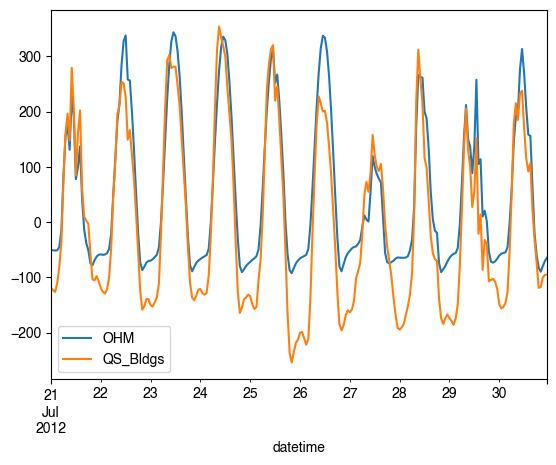

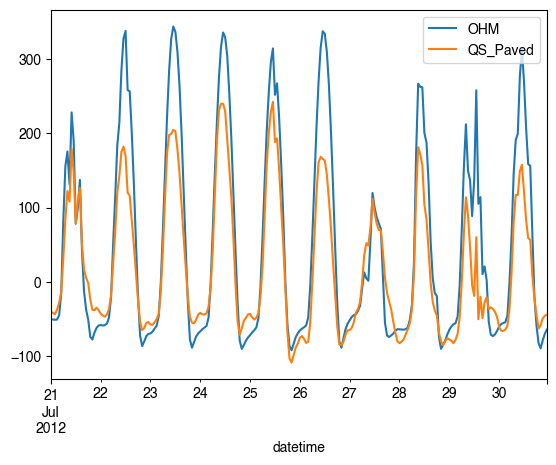

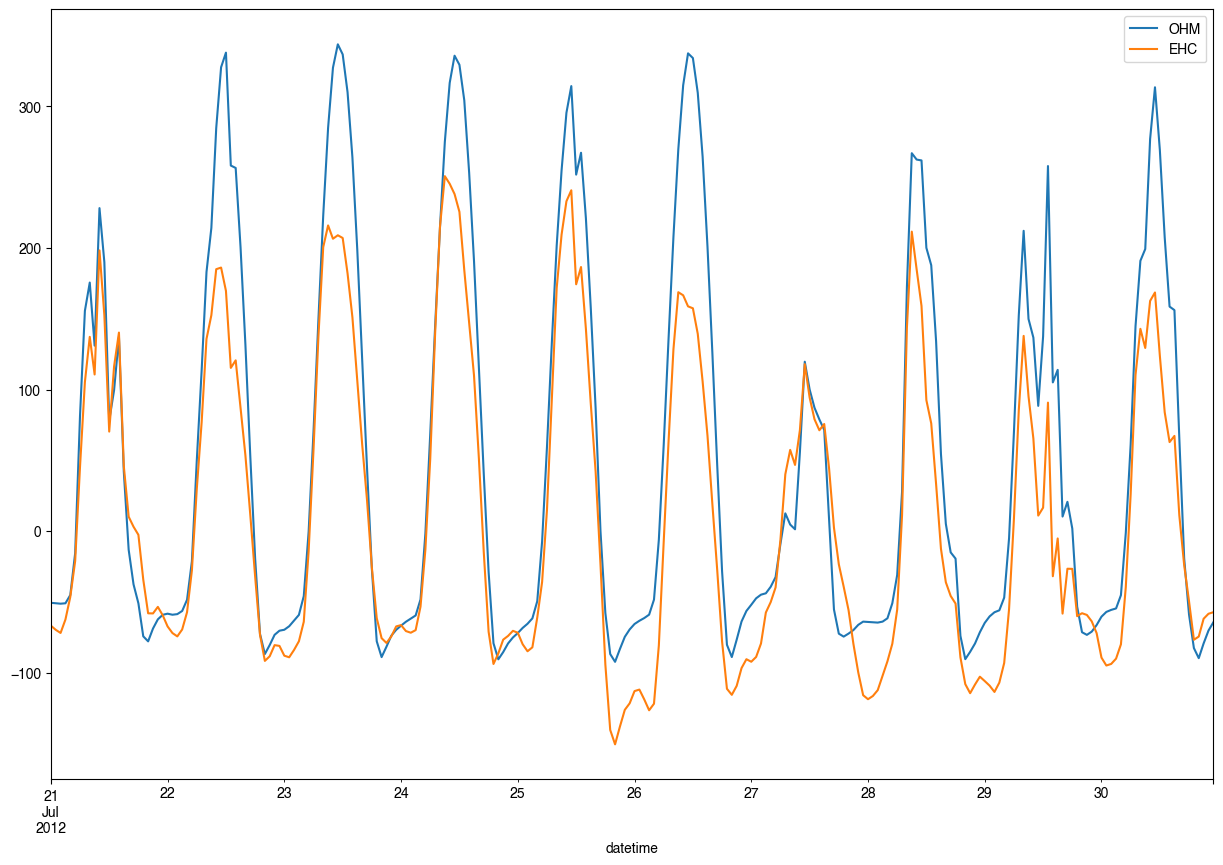

In [149]:
df_comp_qs = pd.concat([df_output_comp["SUEWS"].QS, ser_qs_bldg], axis=1)
_=df_comp_qs.resample("1h").mean().loc['2012-7-21':'2012-7-30',['OHM','QS_Bldgs']].plot()
_=df_comp_qs.resample("1h").mean().loc['2012-7-21':'2012-7-30',['OHM','QS_Paved']].plot()
ax = (
    df_comp_qs.resample("1h")
    .mean()
    .loc["2012-7-21":"2012-7-30", ["OHM", "EHC"]]
    .iloc[:, :2]
    .plot(figsize=(15, 10))
)
# ax.set_aspect(1/3)